In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [24]:
rng = np.random.default_rng()


signal_rate = 0.50206743e-3 # hits/sec (delta fxn)
fourweeks = 3600*24*28 # 4 weeks in seconds
Nsignal = int(signal_rate*fourweeks)

# highmass resolution
E1 = 8.4736 # MeV
dE = 0.8 # MeV (energy bin width)
hm_bg_rate = 0.28096875*dE # hits/sec in bin

# lowmass resolution
E1_lm = E1**2/2/(29*931.5 - 21.895)
dE_lm = E1_lm/10 # MeV (energy bin width)
lm_bg_rate = 846.0666666667023*dE_lm # hits/sec

1214


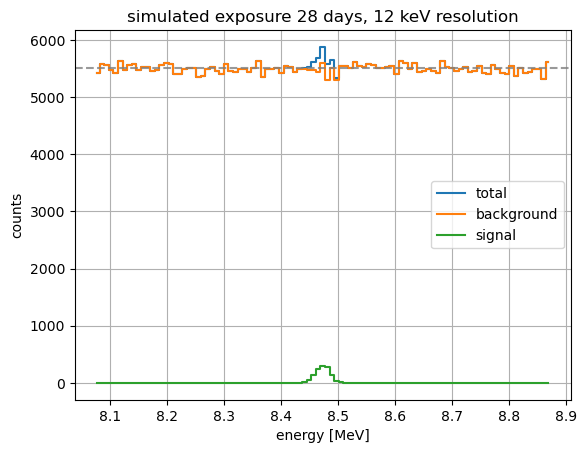

In [25]:
class Resolution:

    def __init__(self, sigma, B = hm_bg_rate/signal_rate, E1 = E1, dE = dE, N = Nsignal, Nbins = 100):
        self.sigma = sigma # resolution of delta-fxn peak
        self.B = B # background rate (relative to signal rate)
        self.dE = dE # width of energy ROI
        self.N_signal = N # number of signal events to sample in ROI
        self.N_background = int(N*B)
        self.E1 = E1 # MeV
        self.exposure_time = self.N_signal/signal_rate # sec
        self.Nbins = Nbins

    def generate_signal(self):
        self.signal = rng.normal(loc = self.E1, scale = self.sigma, size = self.N_signal)
    
    def generate_background(self):
        self.background = self.E1 + self.dE*(rng.uniform(size = self.N_background) - 0.5)


    def analyze(self):
        self.generate_signal()
        self.generate_background()

        # bin edges
        self.Ebins = np.linspace(self.E1 - self.dE/2, self.E1 + self.dE/2, self.Nbins)
        # bin centers
        self.Es = (self.Ebins[1:] + self.Ebins[:-1])/2 
        # bin widths
        self.dEs = np.diff(self.Ebins)

        self.signal_hist, _ = np.histogram(self.signal, bins = self.Ebins)
        self.background_hist, _ = np.histogram(self.background, bins = self.Ebins)
        self.hist = self.signal_hist + self.background_hist

        self.mean = self.hist.sum()
        self.expec = self.mean/(self.Nbins-1)

        self.chi2 = (((self.hist - self.expec)**2)/self.expec).sum()/self.Nbins


    def histogram(self, display_chi = True, **kwargs):
        plt.figure()
        plt.grid()

        plt.xlabel('energy [MeV]')
        plt.ylabel('counts')
        plt.title(f'simulated exposure {self.exposure_time/3600/24:.2g} days, {self.sigma*1e3:.2g} keV resolution')

        plt.step(self.Es, self.hist, where = 'mid', label = 'total')

        plt.step(self.Es, self.background_hist, where = 'mid', label = 'background')
        plt.step(self.Es, self.signal_hist, where = 'mid', label = 'signal')
        plt.legend()

        if display_chi:
            plt.text(self.Ebins[self.Nbins//4], self.hist[self.Nbins//4]/4, f'chi^2 = {self.chi2}')

        plt.axhline(self.expec, color = 'grey', linestyle = 'dashed', alpha = 0.8)



tr = Resolution(E1/700)
tr.analyze()

tr.histogram(display_chi = False)

print(tr.N_signal)

In [26]:
tr.N_signal, tr.N_background

(1214, 543506)

In [27]:
tr.N_background/dE

679382.5

In [28]:
0.28*fourweeks

677376.0000000001

In [29]:
Ntrials = 1000
best_resolution = 5000
worst_resolution = 20
sigmas = E1*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
chis = np.zeros(sigmas.shape)

B = hm_bg_rate/signal_rate

for i, sigma in enumerate(tqdm.tqdm(sigmas)):
    res = Resolution(sigma, N = int(signal_rate*fourweeks), B = B)
    res.analyze()
    chis[i] = res.chi2


100%|██████████| 1000/1000 [00:26<00:00, 38.19it/s]


In [30]:
1e-2/E1

0.0011801359516616316

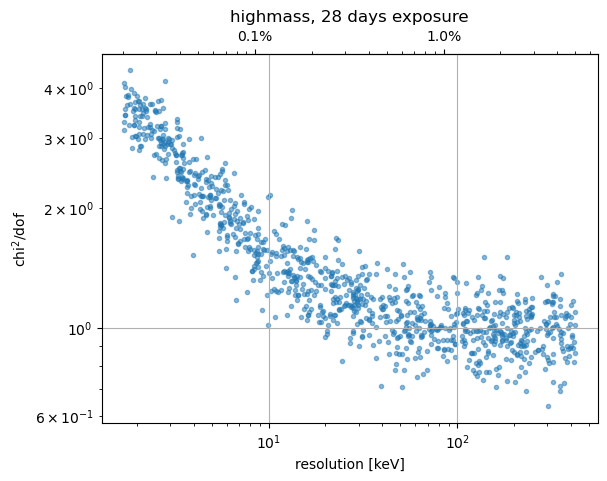

In [31]:
plt.figure()
plt.grid()
plt.loglog()
plt.title('highmass, 28 days exposure')
plt.xlabel('resolution [keV]')
plt.ylabel('chi$^2$/dof')
plt.scatter(sigmas*1e3, chis, marker = '.', alpha = 0.5)
ax = plt.gca()

E_to_P = lambda E: 100*E/(1e3*E1)
P_to_E = lambda P: 1e3*E1*P/100

x2 = ax.secondary_xaxis('top', functions = (E_to_P, P_to_E))
#x2.set_xlabel('percent resolution (%)')
x2.get_xaxis().set_major_formatter('{x}%')

In [32]:
E1/worst_resolution, E1/best_resolution

(0.42367999999999995, 0.0016947199999999998)

In [33]:
100*0.3/E1

3.5404078549848945

In [34]:
541632/fourweeks

0.2238888888888889

In [35]:
Ntrials = 1000
best_resolution = 5000
worst_resolution = 20
sigmas_lm = E1_lm*np.exp(np.log(1/best_resolution) + (np.log(1/worst_resolution) - np.log(1/best_resolution))*rng.random(size = Ntrials))
chis_lm = np.zeros(sigmas_lm.shape)


for i, sigma in enumerate(tqdm.tqdm(sigmas_lm)):
    res_lm = Resolution(sigma, E1 = E1_lm, B = lm_bg_rate/signal_rate, dE = dE_lm)
    res_lm.analyze()
    chis_lm[i] = res_lm.chi2


100%|██████████| 1000/1000 [00:13<00:00, 76.44it/s]


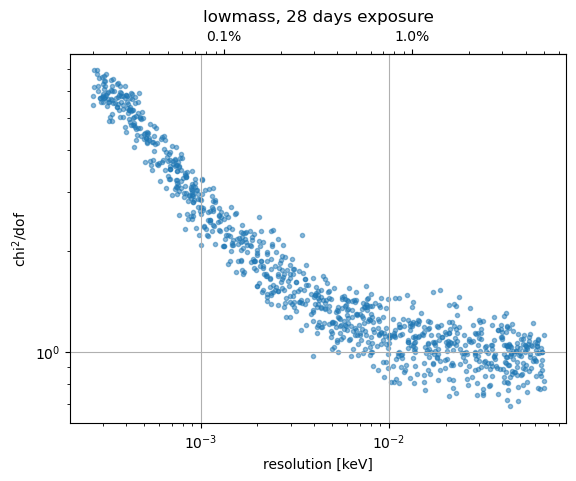

In [36]:
plt.figure()
plt.grid()
plt.loglog()
plt.title('lowmass, 28 days exposure')
plt.xlabel('resolution [keV]')
plt.ylabel('chi$^2$/dof')
plt.scatter(sigmas_lm*1e3, chis_lm, marker = '.', alpha = 0.5)
ax = plt.gca()

E_to_P = lambda E: 100*E/(1e3*E1_lm)
P_to_E = lambda P: 1e3*E1_lm*P/100

x2 = ax.secondary_xaxis('top', functions = (E_to_P, P_to_E))
#x2.set_xlabel('percent resolution (%)')
x2.get_xaxis().set_major_formatter('{x}%')

In [37]:
dE_lm*1000

0.13300783143499617

In [38]:
lm_bg_rate, hm_bg_rate

(0.11253349258277383, 0.224775)

In [39]:
signal_rate

0.00050206743

1214 272106


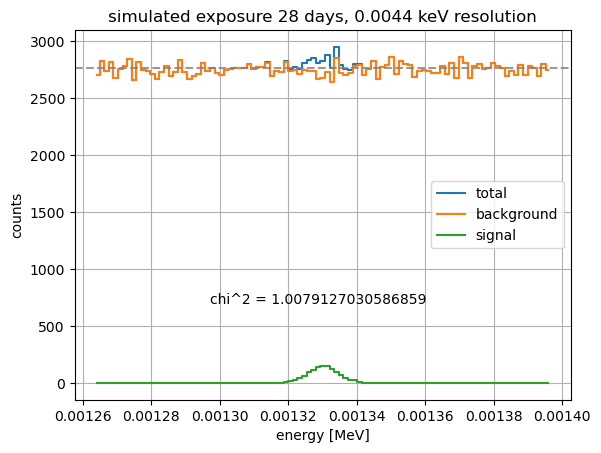

In [40]:
tr_lm = Resolution(E1_lm/300, E1 = E1_lm, B = lm_bg_rate/signal_rate, dE = dE_lm)
tr_lm.analyze()
tr_lm.histogram()
print(tr_lm.N_signal, tr_lm.N_background)

In [41]:
M = (29*931.5 - 21.895) # mass of Si-29 [MeV]
Ep = -M + np.sqrt(M**2 + 2*M*E1)
print(Ep**2 + 2*M*Ep - 2*M*E1)
(E1**2/2/M - Ep**2/2/M)


1.682201400399208e-08


4.173938813185722e-07

In [42]:
Ep

8.472270339079842